In [114]:
import pandas as pd
from gensim.models.doc2vec import  Doc2Vec, TaggedDocument
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import seaborn as sns
# drop the warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [15]:
input_data7 = pd.read_csv('input_data7.csv', 
                          dtype = {'patent_id':object},
                          encoding = 'ISO-8859-1')

In [42]:
input_data8 = pd.read_csv('input_data8.csv',
                          dtype = {'patent_id':object,'citing_patent':object},
                          encoding= 'ISO-8859-1')

In [ ]:
input_data7.head()

In [43]:
ipd8_backup = input_data8
input_data8 = input_data8.dropna()

In [4]:
modell = Doc2Vec.load('patentd2v_model')

In [33]:
citing_pat = input_data8['citing_patent'][2]
j = input_data7.loc[input_data7['patent_id'] == citing_pat].index
j

Int64Index([], dtype='int64')

In [121]:
css_values = []

for index,row in input_data8.iterrows():
    pat = input_data8['patent_id'][index]
    citing_pat = input_data8['citing_patent'][index]
    i = input_data7.loc[input_data7['patent_id'] == pat].index[0]
    j = input_data7.loc[input_data7['patent_id'] == citing_pat].index[0]
    
    vector_1 = modell.docvecs[i]
    vector_2 = modell.docvecs[j]
    css = cosine_similarity(vector_1, vector_2)
    css = css
    css_values.append(css[0][0])
    

In [122]:
input_data8['css'] = css_values

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [65]:
input_data8.head()

,patent_id,title,abstract,grant_year,grant_date,organization,org_number,section_id,class_number,citing_patent,cit_app_year,cit_app_date,css
0,3931070,Plywood adhesive,A phenolic plywood adhesive containing lignos...,1976.0,1976-01-06,Georgia Pacific,6,C,3.0,8945666,2012.0,2012-05-24,0.221066
1,3934111,Apparatus for heating a window,A grid of heating conductors for defrosting a...,1976.0,1976-01-20,Saint Gobain,17,G,7.0,4032745,1975.0,1975-04-17,0.494214
2,3934111,Apparatus for heating a window,A grid of heating conductors for defrosting a...,1976.0,1976-01-20,Saint Gobain,17,G,7.0,4135078,1976.0,1976-06-25,0.368637
4,3935021,Water-resistant gypsum products,"The water resistance of gypsum products, such...",1976.0,1976-01-27,Georgia Pacific,6,C,3.0,4042409,1976.0,1976-04-01,0.412234
5,3935021,Water-resistant gypsum products,"The water resistance of gypsum products, such...",1976.0,1976-01-27,Georgia Pacific,6,C,3.0,4094694,1977.0,1977-05-16,0.488477


In [67]:
input_data8.to_csv('css_doc2vec.csv', index= False)

In [68]:
input_data = pd.read_csv('css_doc2vec.csv', encoding= 'ISO-8859-1')

### Citation counts

In [89]:
X4_citation = input_data.groupby('patent_id')['citing_patent'].nunique() # count of cited patents per patent

X8_citation = input_data.groupby('patent_id')['css'].mean() # mean citation css 

df_counts_css_citation = pd.DataFrame({'citation_count':X4_citation,'mean_css':X8_citation})

# Don't drop. Just take rows where css is finite
df_counts_css_citation = df_counts_css_citation[np.isfinite(df_counts_css_citation['mean_css'])]


df_counts_css_citation.head()

pair_count = pd.DataFrame(df_counts_css_citation['citation_count'].value_counts()) #number of pairs that are cited 1,2,3, etc times 

#df_counts_css_self_citation.loc[df_counts_css_self_citation['citation_count']==1] #780

pair_count = pair_count.rename(columns={'citation_count':'number of patents'})
pair_count['citation_count'] = pair_count.index
pair_count['number_of_pairs'] = pair_count['number of patents'] * pair_count['citation_count']

pair_count.head() #780 patents were cited once, so 780 pairs
                  #394 patents were cited twice, so 788 pairs, etc

,number of patents,citation_count,number_of_pairs
1,820,1,820
2,408,2,816
3,213,3,639
4,159,4,636
5,117,5,585


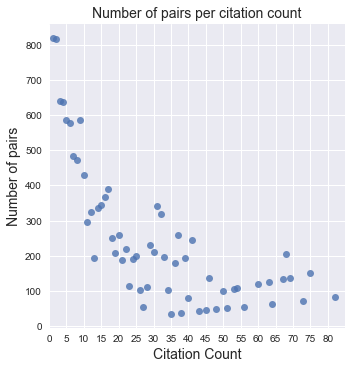

In [90]:
sns.set_style("darkgrid")

g = sns.lmplot(x='citation_count', # horizontal axis
               y='number_of_pairs',   # vertical axis
               data=pair_count,  # data source
               fit_reg=False,    # regression line
               )        

xticks = np.arange(0,85,5).tolist()
#yticks_list = np.arange(0.15,0.30, 0.05).tolist()
#yticks = [ round(elem, 2) for elem in yticks_list ]
g = g.set(xlim=(0,85), xticks=xticks)

plt.title("Number of pairs per citation count", fontsize=14)
plt.xlabel("Citation Count", fontsize=14) #Adding axis labels
plt.ylabel("Number of pairs", fontsize=14)
plt.show()

### Avera

In [91]:
def xfrange(start, stop, step):
    i = 0
    while start + i * step < stop:
        yield start + i * step
        i += 1


average_css_citation = []
citation_count_citation = []

for i in xfrange(1, 85, 1):
    df_counts_css_gt = df_counts_css_citation[df_counts_css_citation['citation_count'] == [i]]
    average_css_citation.append(df_counts_css_gt['mean_css'].mean())
    citation_count_citation.append(i)
    
citation_count_df_citation = pd.DataFrame(np.column_stack([citation_count_citation, average_css_citation]),
                        columns=['citation_count_citation','average_css_citation']) 

citation_count_df_citation = citation_count_df_citation.apply(pd.to_numeric)

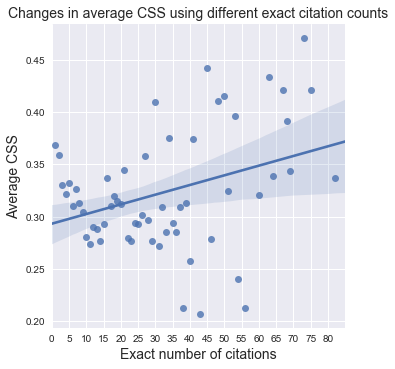

,citation_count_citation,average_css_citation
0,1.0,0.368720
1,2.0,0.358790
2,3.0,0.329807
3,4.0,0.321205
4,5.0,0.331942
5,6.0,0.310406
6,7.0,0.326123
7,8.0,0.312672
8,9.0,0.304016
9,10.0,0.280631


In [93]:
### Visualise 

sns.set_style("darkgrid")

def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

g = sns.lmplot(x='citation_count_citation', # horizontal axis
               y='average_css_citation',   # vertical axis
               data=citation_count_df_citation,  # data source self citation 
               fit_reg=True,    # regression line
               #height=12
               )        

xticks = np.arange(0,85,5).tolist()

g = g.set(xlim=(0,85), xticks=xticks)

plt.title("Changes in average CSS using different exact citation counts", fontsize=14)
plt.xlabel("Exact number of citations", fontsize=14) #Adding axis labels
plt.ylabel("Average CSS", fontsize=14)
plt.show()

citation_count_df_citation.head(10)

In [97]:
vector_1 = modell.docvecs[0]
vector_2 = modell.docvecs[3854]
cosine_similarity(vector_1, vector_2)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.17527699]], dtype=float32)

In [105]:
a = input_data7.sample().index[0]
a

3525

In [120]:
random_css = []


for i in range(0,100):
    a = input_data7.sample().index[0]
    b = input_data7.sample().index[0]
    if a != b:
        vector_1 = modell.docvecs[a]
        vector_2 = modell.docvecs[b]
        css=cosine_similarity(vector_1, vector_2)
        random_css.append(css[0][0])
random_css = np.array(random_css, dtype= float)
np.mean(random_css)

0.19007875576615332